### Séries Temporais

In [ ]:
import pandas as pd
import plotly.express as px
import datetime
import concurrent.futures
import swifter
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import math
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import dateutil

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler

In [ ]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}


In [ ]:
df_sentenciados = pd.read_csv('dados/processados/TRF4_JE_436_2020-12-31-2023-09-30_sentenciados.csv', header='infer', sep=';', compression='zip')
df_nao_sentenciados = pd.read_csv('dados/processados/TRF4_436_2020-12-31-2023-09-30_nao_sentenciados.csv', header='infer', sep=';', compression='zip')
df_tribunal = pd.read_csv('dados/processados/TRF4_JE_436_2020-12-31-2023-09-30.csv', header='infer', sep=';', compression='zip')

In [ ]:
print(df_sentenciados.info())

In [ ]:
print(df_tribunal.info())

In [ ]:
df_sentenciados['data_sentenca'] = df_sentenciados['data_sentenca'].apply(pd.to_datetime, format="%Y-%m-%d")
df_sentenciados['data_ajuizamento'] = df_sentenciados['data_ajuizamento'].apply(pd.to_datetime, format='mixed')
df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].apply(pd.to_datetime, format='mixed')
df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].dt.strftime("%Y-%m-%d")
#serie_sentencas = df_sentenciados.groupby(pd.Grouper(key="data_sentenca", axis=0, freq="M"))['data_sentenca'].count()
#df_sentenciados.dropna(inplace=True)
#df_tribunal.dropna(inplace=True)
serie_sentencas = df_sentenciados.groupby(pd.Grouper(key="data_sentenca", axis=0))['data_sentenca'].count()

In [ ]:
print(df_tribunal.info())

In [ ]:
print(df_sentenciados.info())

In [ ]:
print(serie_sentencas.head(5))

In [ ]:
#serie_ajuizamentos = df_tribunal.groupby(pd.Grouper(key="data_ajuizamento", axis=0, freq="M"))['data_ajuizamento'].count()
serie_ajuizamentos = df_tribunal.groupby(pd.Grouper(key="data_ajuizamento", axis=0))['data_ajuizamento'].count()

In [ ]:
serie_sentencas = serie_sentencas.sort_index()
serie_sentencas.plot(figsize=(15, 11))

In [ ]:
serie_ajuizamentos = serie_ajuizamentos.sort_index()
serie_ajuizamentos.plot(figsize=(15, 11))

In [ ]:
def show_tendencia(ts, rm_size):
  df_show = pd.DataFrame()

  df_show['serie'] = ts.values[rm_size:]
  df_show['rm'] = ts.rolling(rm_size).mean().values[rm_size:]

  df_show['date'] = ts.index.to_list()[rm_size:]
  df_show.set_index('date', inplace=True)
  df_show.plot()
  plt.show()

In [ ]:
show_tendencia(serie_sentencas, 7)

In [ ]:
def arima_fit_predict(ts, m, horizon, test_size):
  ts_train = ts[0:-(test_size+(horizon-1))].values
  ts_test = ts[-(test_size+(horizon-1)):].values

  model = auto_arima(ts_train, #X=None,
            start_p=2, start_q=2, max_p=8, max_d=5,
            max_q=8, start_P=1, start_Q=1, max_P=2,
            max_D=3, max_Q=5, max_order=30, m=m,
            stepwise=True, trace=True, maxiter=300)

  direct_predict = model.predict(ts_test.shape[0])

  prevs_h_steps = []

  for t in tqdm(ts_test):
    prevs_h_steps.append(model.predict(horizon)[horizon-1])
    model.update(t)

  return prevs_h_steps[0:test_size], direct_predict[-test_size:]

In [ ]:
test_size = 365
m = 7
horizon = 1
ts = serie_sentencas
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

In [ ]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result.plot()

In [ ]:
kpss = KPSSTest()
print(kpss.should_diff(serie_sentencas))

In [ ]:
show_tendencia(serie_ajuizamentos, 7)

In [ ]:
test_size = 365
m = 7
horizon = 1
ts = serie_ajuizamentos
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

In [ ]:
kpss = KPSSTest()
print(kpss.should_diff(serie_ajuizamentos))

In [ ]:
df_result_ajuizamento = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result_ajuizamento.plot()

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['arima_1_steps']:

  y_true = df_result_ajuizamento['real']
  y_pred = df_result_ajuizamento[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

pd.DataFrame(metric_results)

### Prophet

In [ ]:
print(serie_ajuizamentos)

In [13]:
df_trf_2018 = pd.read_csv('dados/TRF4_JE_2018-01-01.csv', header='infer', sep=';')
df_trf_2018['data_ajuizamento'] = df_trf_2018['data_ajuizamento'].swifter.apply(dateutil.parser.parse)



Pandas Apply:   0%|          | 0/1888037 [00:00<?, ?it/s]

AttributeError: module 'datetime' has no attribute 'strptime'

In [18]:
df_trf_2018['data_ajuizamento'] = df_trf_2018['data_ajuizamento'].swifter.apply(datetime.datetime.date)
serie_ajuizamentos_trf4_2018 = df_trf_2018.groupby(pd.Grouper(key="data_ajuizamento", axis=0))['data_ajuizamento'].count()
serie_ajuizamentos_trf4_2018 = serie_ajuizamentos_trf4_2018.sort_index()

Pandas Apply:   0%|          | 0/1888037 [00:00<?, ?it/s]

In [19]:
#df_prophet = serie_ajuizamentos.to_frame()
df_prophet = serie_ajuizamentos_trf4_2018.to_frame()
df_prophet.rename_axis('ds', axis='columns')
df_prophet.rename(columns={'data_ajuizamento': 'y'}, inplace=True)
df_prophet.reset_index(inplace=True)
df_prophet.rename(columns={'data_ajuizamento': 'ds'}, inplace=True)
print(df_prophet.head(2))
print(df_prophet.columns)

           ds    y
0  2018-01-01   20
1  2018-01-02  252
Index(['ds', 'y'], dtype='object')


In [51]:
recesso_judiciario = pd.DataFrame({
  'holiday': 'recesso_judiciario',
  'ds': pd.to_datetime(['2018-12-19', '2019-12-19', 
                        '2020-12-19', '2021-12-19',
                        '2022-12-19', '2023-12-19',
                        '2024-12-19', '2025-12-19']),
  'lower_window': 0,
  'upper_window': 18,
})

In [79]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

m = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.01,interval_width=0.99, holidays=recesso_judiciario, yearly_seasonality=20)
m.add_country_holidays(country_name='BR')
m.fit(df_prophet)
df_cv = cross_validation(m, initial='1080 days', period='180 days', horizon = '360 days', parallel="processes")
#df_cv.head()

02:43:37 - cmdstanpy - INFO - Chain [1] start processing
02:43:38 - cmdstanpy - INFO - Chain [1] done processing
02:43:39 - cmdstanpy - INFO - Chain [1] start processing
02:43:39 - cmdstanpy - INFO - Chain [1] start processing
02:43:40 - cmdstanpy - INFO - Chain [1] start processing
02:43:40 - cmdstanpy - INFO - Chain [1] start processing
02:43:40 - cmdstanpy - INFO - Chain [1] done processing
02:43:41 - cmdstanpy - INFO - Chain [1] done processing
02:43:41 - cmdstanpy - INFO - Chain [1] done processing
02:43:41 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,1.384334e+06,1176.577111,636.681707,1.077409,0.312142,0.563490,0.909722
1,37 days,1.437398e+06,1198.915387,666.477644,1.117637,0.337414,0.580519,0.902778
2,38 days,1.479059e+06,1216.165780,689.042611,1.177317,0.372547,0.590035,0.895833
3,39 days,1.488821e+06,1220.172484,699.073486,1.236759,0.379188,0.591279,0.895833
4,40 days,1.497553e+06,1223.745586,705.730536,1.219333,0.375575,0.579403,0.895833


In [74]:
df_p['smape'].min()

0.5186613359110869

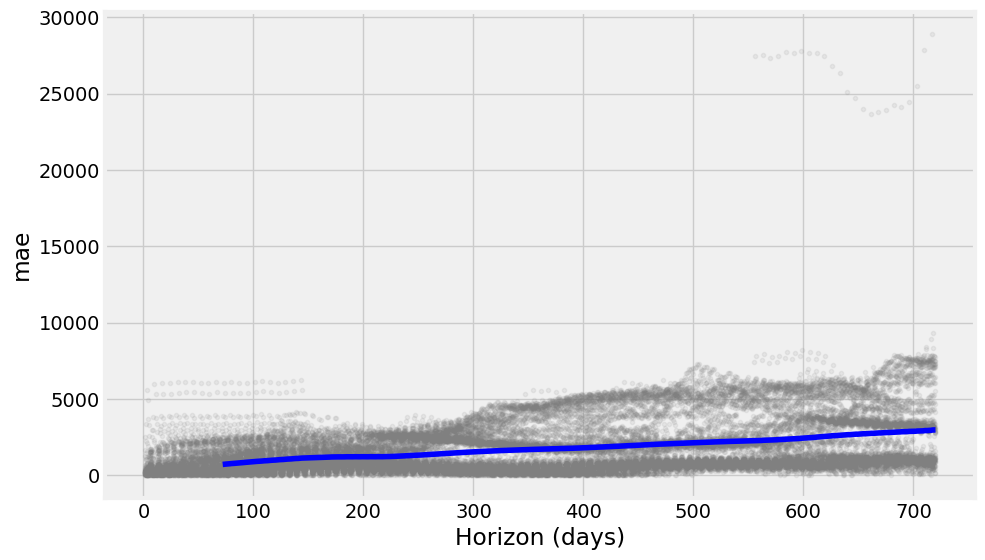

In [75]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
fig.show()

In [85]:
lista_configuracoes = list()

def get_mdape(e):
    return e[3]

for inicial in range(366,1440,1):
    for periodo in range(3,365,4):
        for horizonte in range(90,730,30):
            m = Prophet(changepoint_prior_scale=0.8, seasonality_prior_scale=0.01,interval_width=0.99, holidays=recesso_judiciario, yearly_seasonality=20)
            m.add_country_holidays(country_name='BR')
            m.fit(df_prophet)
            df_cv = cross_validation(m, initial=(str(inicial) + 'days'), period=(str(periodo) + 'days'), horizon =(str(horizonte) + 'days'), parallel="processes")
            df_p = performance_metrics(df_cv)
            lista_configuracoes.append([inicial, periodo, horizonte, df_p['coverage'].max(), df_p['mdape'].min()])
            
print(lista_configuracoes.sort(key=get_mdape))                

03:03:53 - cmdstanpy - INFO - Chain [1] start processing
03:03:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
03:03:56 - cmdstanpy - INFO - Chain [1] start processing
03:03:56 - cmdstanpy - INFO - Chain [1] start processing
03:03:56 - cmdstanpy - INFO - Chain [1] start processing
03:03:57 - cmdstanpy - INFO - Chain [1] start processing
03:03:57 - cmdstanpy - INFO - Chain [1] start processing
03:03:57 - cmdstanpy - INFO - Chain [1] start processing
03:03:57 - cmdstanpy - INFO - Chain [1] done processing
03:03:57 - cmdstanpy - INFO - Chain [1] done processing
03:03:57 - cmdstanpy - INFO - Chain [1] start processing
03:03:57 - cmdstanpy - INFO - Chain [1] start processing
03:03:57 - cmdstanpy - INFO - Chain [1] start processing
03:03:57 - cmdstanpy - INFO - Chain [1] start processing
03:03:57 - cmdstanpy - INFO - Chain [1] done processing
03:03:57 - cmdstanpy - INFO - Chain [1] done 

TypeError: list.append() takes exactly one argument (5 given)

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 0.6, 0.8, 0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1, 5, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

02:56:36 - cmdstanpy - INFO - Chain [1] start processing
02:56:37 - cmdstanpy - INFO - Chain [1] done processing
02:56:38 - cmdstanpy - INFO - Chain [1] start processing
02:56:38 - cmdstanpy - INFO - Chain [1] done processing
02:56:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
02:56:38 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
02:56:38 - cmdstanpy - INFO - Chain [1] start processing
02:56:38 - cmdstanpy - INFO - Chain [1] done processing
02:56:38 - cmdstanpy - INFO - Chain [1] start processing
02:56:38 - cmdstanpy - INFO - Chain [1] start processing
02:56:38 - cmdstanpy - INFO - Chain [1] done processing
02:56:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:56:38 - cmdstanpy - INFO - Chain [1] done processing
02:56:38 - cmdstanpy - ERROR - Chain [1] error: error during proce

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  1249.531561
1                     0.001                     0.10  1246.983201
2                     0.001                    10.00  1247.813612
3                     0.010                     0.01  1231.497152
4                     0.010                     0.10  1229.785599
5                     0.010                    10.00  1229.696795
6                     0.100                     0.01  1222.502688
7                     0.100                     0.10  1217.353209
8                     0.100                    10.00  1218.066272
9                     0.500                     0.01  1209.621996
10                    0.500                     0.10  1217.718674
11                    0.500                    10.00  1217.471610
12                    0.800                     0.01  1212.025166
13                    0.800                     0.10  1224.109794
14        

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
